In [128]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import logging
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
import random


In [129]:
# Konfigurasi dasar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("recommendation_system.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()


In [130]:
# Membaca dataset
try:
    with open("./dataset.JSON", 'r', encoding='utf-8') as file:
        data = json.load(file)
    logger.info("Dataset berhasil dimuat.")
except Exception as e:
    logger.error(f"Error saat memuat dataset: {e}")
    raise e


2025-01-12 17:39:00,377 - INFO - Dataset berhasil dimuat.


In [131]:
# Inisialisasi LabelEncoder untuk item titles
item_encoder = LabelEncoder()

# Kumpulkan semua item titles untuk encoding
all_item_titles = []
for entry in data:
    recommendations = entry.get("recommendation", [])
    for recommendation in recommendations:
        item_title = recommendation.get("title")
        if item_title:
            all_item_titles.append(item_title)

# Encode item titles
item_titles_encoded = item_encoder.fit_transform(all_item_titles)
logger.info("Item titles berhasil di-encode.")


2025-01-12 17:39:00,387 - INFO - Item titles berhasil di-encode.


In [132]:
# Membuat mapping itemID ke type
item_types = {}
for entry in data:
    for recommendation in entry.get('recommendation', []):
        item_title = recommendation.get("title")
        item_type = recommendation.get("type")
        if item_title is None or item_type is None:
            logger.warning(f"Title atau Type kosong dalam rekomendasi: {recommendation}")
            continue
        try:
            item_id = item_encoder.transform([item_title])[0]
            if item_id in item_types:
                if item_types[item_id] != item_type:
                    logger.warning(f"Item ID {item_id} memiliki tipe yang berbeda: {item_types[item_id]} vs {item_type}")
            else:
                item_types[item_id] = item_type
        except ValueError:
            logger.warning(f"Item title '{item_title}' tidak dikenali oleh item_encoder.")
            continue

logger.info(f"Mapping itemID ke type telah dibuat. Contoh: {list(item_types.items())[:5]}")


2025-01-12 17:39:01,462 - WARNING - Item ID 753 memiliki tipe yang berbeda: destinasi vs buku
2025-01-12 17:39:01,746 - INFO - Mapping itemID ke type telah dibuat. Contoh: [(np.int64(909), 'destinasi'), (np.int64(713), 'destinasi'), (np.int64(365), 'destinasi'), (np.int64(1483), 'destinasi'), (np.int64(122), 'destinasi')]


In [133]:
# Definisikan skala rating maksimum per type
type_max_rating = {
    'buku': 10,
    'destinasi': 5
}


In [134]:
# Data Preparation: Assign ratings berdasarkan emosi
logger.info("Mulai memproses data dengan rating berdasarkan emosi dominan.")
processed_data = []

for entry in data:
    emotions = entry.get("emotionDominant", [])
    recommendations = entry.get("recommendation", [])
    # msgEmotion diambil untuk digunakan nanti
    msgEmotion = entry.get("msgEmotion", "")
    for recommendation in recommendations:
        item_title = recommendation.get("title")
        item_type = recommendation.get("type")
        if item_title is None or item_type is None:
            logger.warning(f"Title atau Type kosong dalam rekomendasi: {recommendation}")
            continue
        # Tetapkan rating berdasarkan emosi
        if any(emotion.lower() in ["gembira", "bahagia", "senang"] for emotion in emotions):
            rating = 5
        elif any(emotion.lower() in ["marah", "kesal", "sedih"] for emotion in emotions):
            rating = 2
        else:
            rating = 3  # Netral
        # Pastikan rating adalah numerik
        try:
            rating = float(rating)
        except ValueError:
            logger.warning(f"Rating tidak valid untuk item_title {item_title}. Mengabaikan entri ini.")
            continue
        # Encode item title
        try:
            item_id = item_encoder.transform([item_title])[0]
        except ValueError:
            logger.warning(f"Item title '{item_title}' tidak dikenali oleh item_encoder.")
            continue
        processed_data.append({
            'itemID': item_id,
            'rating': rating,
            'type': item_type,
            'msgEmotion': msgEmotion  # Tambahkan msgEmotion ke dalam processed_data
        })

# Cek apakah ada data yang valid
if not processed_data:
    logger.error("Tidak ada data yang diproses dengan rating yang valid.")
    raise ValueError("Dataset tidak memiliki data dengan rating yang valid.")

# Membuat DataFrame
df = pd.DataFrame(processed_data)
logger.info(f"DataFrame dibuat dengan {df.shape[0]} baris.")
logger.info(df.head())


2025-01-12 17:39:01,776 - INFO - Mulai memproses data dengan rating berdasarkan emosi dominan.
2025-01-12 17:39:03,141 - INFO - DataFrame dibuat dengan 1709 baris.
2025-01-12 17:39:03,142 - INFO -    itemID  rating       type  \
0     909     3.0  destinasi   
1     713     3.0  destinasi   
2     365     3.0  destinasi   
3    1483     3.0  destinasi   
4     122     3.0  destinasi   

                                          msgEmotion  
0  Kamu Kesulitan yang dihadapi membuat semuanya ...  
1  Kamu Kejadian yang memalukan membuat hati tera...  
2  Kamu Hal yang lucu dan menggemaskan membuat se...  
3  Kamu Mencari jawaban di antara pertanyaan yang...  
4  Kamu Perasaan yang sulit ditahan karena emosi ...  


2025-01-12 17:39:03,156 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-12 17:39:03,160 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-12 17:39:03,196 - INFO - Plot distribusi rating berhasil dibuat dan disimpan sebagai 'rating_distribution.png'.


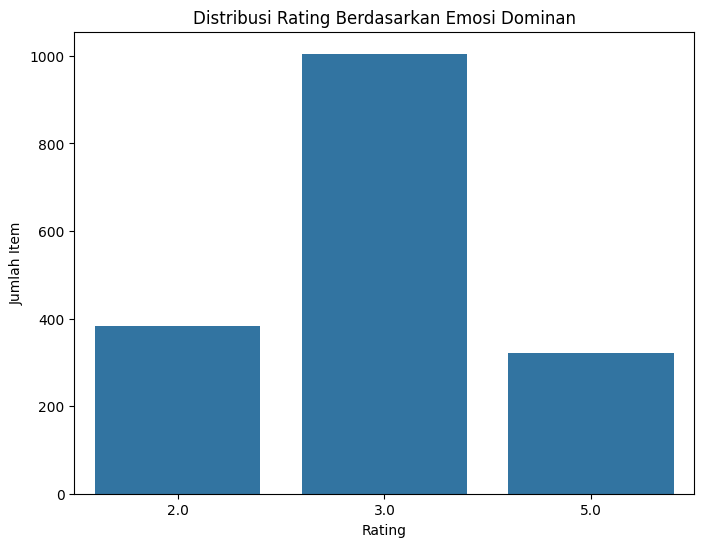

In [135]:
# Visualisasi Distribusi Rating
plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=df)
plt.title('Distribusi Rating Berdasarkan Emosi Dominan')
plt.xlabel('Rating')
plt.ylabel('Jumlah Item')
plt.savefig("rating_distribution.png")
logger.info("Plot distribusi rating berhasil dibuat dan disimpan sebagai 'rating_distribution.png'.")
plt.show()


In [136]:
# Menghitung rating rata-rata per item
df_item_ratings = df.groupby(['itemID', 'type'])['rating'].mean().reset_index()
logger.info("Rating rata-rata per item telah dihitung.")
logger.info(df_item_ratings.head())


2025-01-12 17:39:03,231 - INFO - Rating rata-rata per item telah dihitung.
2025-01-12 17:39:03,232 - INFO -    itemID  type  rating
0       0  buku     3.0
1       1  buku     5.0
2       2  buku     5.0
3       3  buku     3.0
4       4  buku     2.0


In [137]:
# Fungsi untuk menghasilkan rekomendasi berdasarkan emosi
def generate_recommendations(emotion_dominant, top_n=5):
    logger.info(f"Memulai rekomendasi dengan emosi dominan: {emotion_dominant}")
    
    # Tetapkan bobot emosi
    if any(emotion.lower() in ["gembira", "bahagia", "senang"] for emotion in emotion_dominant):
        # Emosi positif, preferensi tinggi
        rating_multiplier = 1.2
    elif any(emotion.lower() in ["marah", "kesal", "sedih"] for emotion in emotion_dominant):
        # Emosi negatif, preferensi rendah
        rating_multiplier = 0.8
    else:
        # Emosi netral
        rating_multiplier = 1.0
    
    logger.info(f"Rating multiplier berdasarkan emosi: {rating_multiplier}")
    
    # Hitung skor untuk setiap item
    # Pastikan untuk menggunakan .map() agar bisa mengakses nilai dari dictionary
    df_item_ratings['score'] = df_item_ratings['rating'] * rating_multiplier / df_item_ratings['type'].map(type_max_rating)
    
    # Sort item berdasarkan skor
    df_sorted = df_item_ratings.sort_values(by='score', ascending=False)
    
    # Ambil 3 buku dan 2 destinasi teratas
    top_buku = df_sorted[df_sorted['type'] == 'buku'].head(3)
    top_destinasi = df_sorted[df_sorted['type'] == 'destinasi'].head(2)
    
    recommendations = pd.concat([top_buku, top_destinasi])
    
    # Jika kurang dari top_n, tambahkan secara acak dari tipe yang sama
    if recommendations.shape[0] < top_n:
        needed = top_n - recommendations.shape[0]
        remaining_items = df_sorted[~df_sorted['itemID'].isin(recommendations['itemID'])]
        # Pilih item secara acak dari remaining_items
        if needed <= len(remaining_items):
            random_items = remaining_items.sample(n=needed)
        else:
            random_items = remaining_items
        recommendations = pd.concat([recommendations, random_items])
    
    # Ambil item titles
    recommended_items = []
    seen_titles = set()
    # Kumpulkan msgEmotion berdasarkan emosi dominan
    matching_entries = [entry for entry in data if any(emotion.lower() in [e.lower() for e in entry.get("emotionDominant", [])] for emotion in emotion_dominant)]
    msg_emotions = [entry.get("msgEmotion", "") for entry in matching_entries]
    if msg_emotions:
        # Pilih msgEmotion yang paling sering muncul
        msg_emotion = max(set(msg_emotions), key=msg_emotions.count)
    else:
        msg_emotion = "Tidak ada data pengguna. Berikut adalah rekomendasi teratas berdasarkan rating tertinggi dan beberapa rekomendasi acak."
    
    for _, row in recommendations.iterrows():
        try:
            item_title = item_encoder.inverse_transform([int(row['itemID'])])[0]
        except ValueError:
            logger.warning(f"Item ID {row['itemID']} tidak dikenali oleh item_encoder.")
            continue
        if item_title in seen_titles:
            continue
        # Cari detail item dari dataset
        for entry in data:
            for rec in entry.get('recommendation', []):
                if rec.get("title") == item_title:
                    recommended_items.append({
                        "title": rec.get("title", ""),
                        "image": rec.get("image", ""),
                        "desc": rec.get("desc", ""),
                        "type": rec.get("type", "")
                    })
                    seen_titles.add(item_title)
                    logger.info(f"Rekomendasi ditambahkan: {item_title}")
                    break
            if item_title in seen_titles:
                break
        if len(recommended_items) >= top_n:
            break
    
    logger.info(f"Total rekomendasi yang dikembalikan: {len(recommended_items)}")
    return {
        "msgEmotion": msg_emotion,
        "recommendation": recommended_items[:top_n]
    }


In [138]:
# Contoh Penggunaan Fungsi generate_recommendations
# Misalnya, emosi dominan adalah "Senang", "Bahagia", dan "Terharu"
emotion_input = ["Senang", "Bahagia", "Terharu"]
user_recommendations = generate_recommendations(emotion_input, top_n=5)
logger.info(f"Pesan Emosi: {user_recommendations['msgEmotion']}")

# Display the recommendations in a tabular format using IPython display
try:
    # Print the emotion message
    print(user_recommendations["msgEmotion"])
    
    # Create DataFrame for recommendations
    df_rekom = pd.DataFrame(user_recommendations["recommendation"])[['title', 'image', 'desc', 'type']]
    
    # Display the DataFrame in a tabular format
    display(df_rekom)
except KeyError as e:
    logger.error(f"Kesalahan dalam membuat DataFrame rekomendasi: {e}")
    print(f"Kesalahan: {e}")
    print("Isi Rekomendasi:", user_recommendations.get("recommendation", []))


2025-01-12 17:39:03,257 - INFO - Memulai rekomendasi dengan emosi dominan: ['Senang', 'Bahagia', 'Terharu']
2025-01-12 17:39:03,258 - INFO - Rating multiplier berdasarkan emosi: 1.2
2025-01-12 17:39:03,262 - INFO - Rekomendasi ditambahkan: #FriendButMarried
2025-01-12 17:39:03,263 - INFO - Rekomendasi ditambahkan: 12:00 A.M.
2025-01-12 17:39:03,264 - INFO - Rekomendasi ditambahkan: Stay with Me
2025-01-12 17:39:03,265 - INFO - Rekomendasi ditambahkan: Wisata Kuliner Pecenongan
2025-01-12 17:39:03,265 - INFO - Rekomendasi ditambahkan: Wisata Lereng Kelir
2025-01-12 17:39:03,266 - INFO - Total rekomendasi yang dikembalikan: 5
2025-01-12 17:39:03,266 - INFO - Pesan Emosi: Kamu Harapan yang tak terpenuhi membuat hati terasa kosong. dan Hal yang lucu dan menggemaskan membuat senyum tak bisa berhenti. dan Kebahagiaan sederhana membawa senyuman di wajah.


Kamu Harapan yang tak terpenuhi membuat hati terasa kosong. dan Hal yang lucu dan menggemaskan membuat senyum tak bisa berhenti. dan Kebahagiaan sederhana membawa senyuman di wajah.


,title,image,desc,type
0,#FriendButMarried,https://picsum.photos/seed/831/200/300,Ayudia (Vanesha Prescilla) and Ditto (Adipati ...,buku
1,12:00 A.M.,https://picsum.photos/seed/599/200/300,,buku
2,Stay with Me,https://picsum.photos/seed/65/200/300,Boy Dimas (Boy William) and Deyna (Ully Triani...,buku
3,Wisata Kuliner Pecenongan,https://picsum.photos/seed/842/200/300,Pecenongan merupakan salah satu surga kuliner ...,destinasi
4,Wisata Lereng Kelir,https://picsum.photos/seed/35/200/300,Wisata yang ada di kawasan gunung Kelir ini me...,destinasi


2025-01-12 17:39:03,326 - INFO - Plot distribusi tipe item dalam rekomendasi berhasil dibuat dan disimpan sebagai 'recommendation_types_distribution.png'.


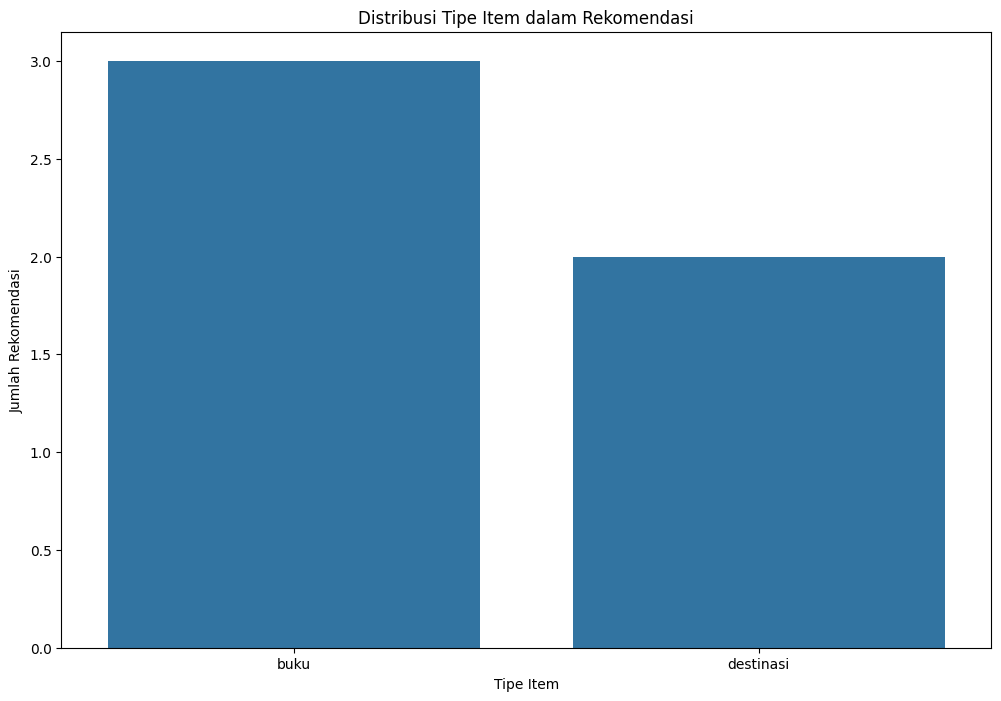

In [139]:
# Visualisasi Rekomendasi
def visualize_recommendations(recommendations):
    plt.figure(figsize=(12, 8))
    types = [item['type'] for item in recommendations]
    sns.countplot(x=types)
    plt.title('Distribusi Tipe Item dalam Rekomendasi')
    plt.xlabel('Tipe Item')
    plt.ylabel('Jumlah Rekomendasi')
    plt.savefig("recommendation_types_distribution.png")
    logger.info("Plot distribusi tipe item dalam rekomendasi berhasil dibuat dan disimpan sebagai 'recommendation_types_distribution.png'.")
    plt.show()

visualize_recommendations(user_recommendations["recommendation"])


In [140]:
# Menyimpan Rekomendasi ke File JSON
import json

def save_recommendations(recommendations, filename="recommendations.json"):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(recommendations, f, ensure_ascii=False, indent=4)
    logger.info(f"Rekomendasi berhasil disimpan ke {filename}.")

save_recommendations(user_recommendations)


2025-01-12 17:39:03,367 - INFO - Rekomendasi berhasil disimpan ke recommendations.json.


2025-01-12 17:39:03,424 - INFO - Plot distribusi rating per tipe item berhasil dibuat dan disimpan sebagai 'rating_per_type.png'.


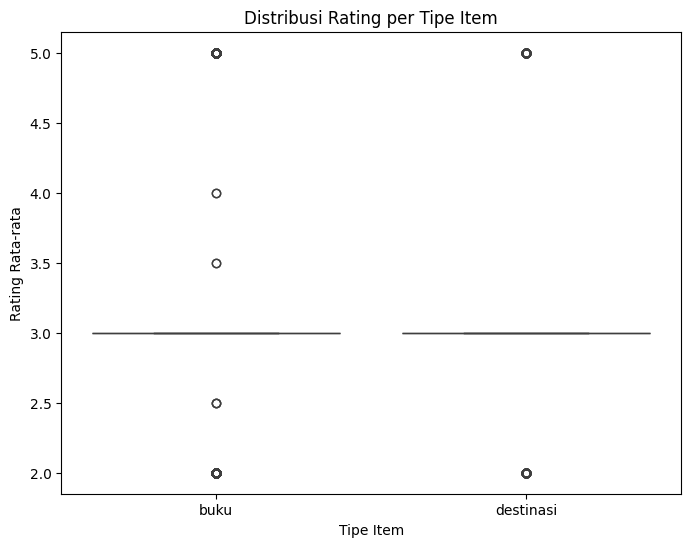

In [141]:
# Analisis Tambahan (Opsional)
# Misalnya, melihat korelasi antara rating dan tipe
plt.figure(figsize=(8,6))
sns.boxplot(x='type', y='rating', data=df_item_ratings)
plt.title('Distribusi Rating per Tipe Item')
plt.xlabel('Tipe Item')
plt.ylabel('Rating Rata-rata')
plt.savefig("rating_per_type.png")
logger.info("Plot distribusi rating per tipe item berhasil dibuat dan disimpan sebagai 'rating_per_type.png'.")
plt.show()
